In [1]:
import numpy as np
import pandas as pd
from scipy import integrate
from scipy.stats import multivariate_normal
from scipy.stats import tmean, tstd
from sklearn.utils import resample

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import cnames
from matplotlib import animation
from IPython.display import HTML

plt.style.use('seaborn-white')
sns.set_style("ticks")
sns.set_context("talk")
%matplotlib inline

In [2]:
import sys
sys.path.append('/Users/agarbuno/gDrive/postdoc/python/clima/dean-code/')

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from ces.calibrate import *

/Users/agarbuno/anaconda2/envs/gpflow/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


#  Problem setup 

In [5]:
import ces.darcy as darcy

In [6]:
model = darcy.model()

In [7]:
model.start(mpath = r'./mfiles')
model.set_rnd_seed()
model.set_initial()
model.n_obs = 50
model.model_name = 'darcy-flow'

In [8]:
# Forward model G(u) in D. Take the KL coeffs and returns pressure in D. 
U = model(model.ustar, full_solution = True);

In [9]:
# Generate the random locations in the grid
xs, ys = np.meshgrid(np.linspace(0, 1, int(model.Nmesh)), np.linspace(0, 1, int(model.Nmesh)))
np.random.seed(1)
grid_pts    = np.vstack((xs.flatten(), ys.flatten()))           # Flat the (x,y) coordinates
model.obs_index = np.random.choice(int(model.p), model.n_obs, replace=False, 
                             p = U /U.sum())                    # Sample without replacement 
model.obs_locs = grid_pts[:, model.obs_index]                   # Recover the random (x,y) coordinates

In [10]:
# Generate the truth at the locations
y_obs = model(model.ustar)

In [11]:
# Compute the truth for the permeability field given KL coeffs
theta = np.array(model.eval_rf(model.ustar))

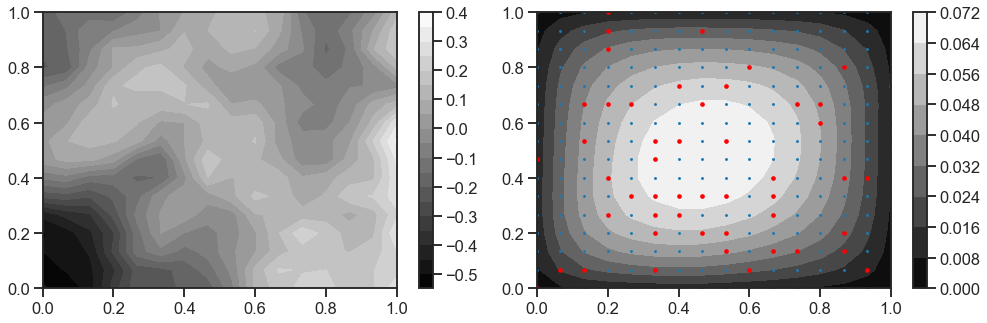

In [12]:
# Plotting the grid and both log-permeability and pressure. 
# Blue dots are grid points, red points are measurement locations. 
fig, axes = plt.subplots(1,2,figsize = (14, 5))
cmap = plt.get_cmap('gray');
f0 = axes[0].contourf(xs, ys, theta, 20, cmap = cmap)
fig.colorbar(f0, ax = axes[0]);

f1 = axes[1].contourf(xs, ys, U.reshape(int(model.Nmesh), -1), 10, cmap = cmap)
fig.colorbar(f1, ax = axes[1]);

axes[1].scatter(xs.flatten(), ys.flatten(), 2);
axes[1].scatter(model.obs_locs[0], model.obs_locs[1], 10, 'red');

axes[1].set_ylim(0,1);
axes[1].set_xlim(0,1);

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [13]:
y_smooth = y_obs.copy()

In [14]:
#  Add noise to observations for inverse problem setup. 
gamma = 0.005      
Gamma = gamma**2 * np.identity(model.n_obs)
y_obs = y_obs + 1.0 * gamma * np.random.normal(0,1,model.n_obs)

In [15]:
tqdm.write('Remember, the number of params is: %s'%(len(model.ustar)))

Remember, the number of params is: 256


# Ensemble Kalman Sampler

In [16]:
Jnoise = np.linalg.cholesky(Gamma)

def run_neks(J, model, **kwargs): 
    """
    INPUT: 
             J :  The number of ensemble members. 
         model :  The forward model for the inversion. Needs to be a callable object with property model.type = 'map'
         kwargs:  Variable dictionary with {keyword: value} arguments. 
    
    OUTPUT: 
        eks object with: 
            eks.Uall  - trajectory of ensemble 
            eks.Ustar - ensemble at last iteration

            eks.Gall  - trajectory of forward evaluations for ensemble members
            eks.Gstar - forward evaluations for last iteration
            
            eks.metrics - contain several metrics of ensemble performance, mainly to assess collapse towards truth and 
                          collapse within ensemble, also, fictitious time 
                
    """
    
    # EKS setup: 
    # Initialize the object as a sampling ensemble kalman algorithm. 
    eks          = sampling(p = model.p, n_obs = model.n_obs, J = J)
    
    # Pass the truth to compute some statistics for the ensemble. 
    eks.ustar    = model.ustar.reshape(model.p,-1)

    # Number of maxmimum iterations
    eks.T        = 200
    
    # Prior specification 
    eks.mu       = 0.0 * np.ones((model.p,)).reshape(model.p,-1)
    eks.sigma    = 100. * np.identity(model.p)
    
    # Computing variables
    eks.parallel = False                   # No parallel evaluation of G
    eks.mute_bar = True                    # Mutes an additional progress bar
    eks.nexp     = kwargs.get('nexp', '')  # Sets an additional string for saving purposes
    
    # Location of where to save the ensemble members
    eks.directory = '/Users/agarbuno/gDrive/postdoc/python/clima/dean-code/'
    
    # Random initial ensemble 
    np.random.seed(kwargs.get('nexp', 1))
    U0 = 10 * np.random.normal(0, 1, [eks.p, J])
    
    # Run the whole EKS procedure until it reaches time t_tol or maximum number of iterations are exhausted. 
    # Save online option allows to save the trajectory on disk as numpy objects. 
    eks.run(y_obs, U0, model, Gamma, Jnoise, save_online = True, t_tol = 5)

    return eks

In [17]:
model.model_name = 'darcy-flow'

In [20]:
Js = [int(model.p/15), int(model.p/5), int(model.p/2), int(model.p + 2), int(2 * model.p), int(3 * model.p)]
Js

[17, 51, 128, 258, 512, 768]

In [19]:
np.random.seed(1)

neks = {}
for J in tqdm(Js, desc = 'Ensembles: ', position = 0):
    neks['eks-'+str(J).zfill(3)] = []
    for jj in range(1):
        neks['eks-'+str(J).zfill(3)].append(run_neks(J, model, nexp = jj))